# Amazon Recosys

# Objective: 
Build a recommendation system to recommend products to
customers based on the their previous ratings for other
products.

# Details

### Data Description: 

Amazon Reviews data (​data source​) The repository has several datasets. For this case study, we are using the Electronics dataset.

### Domain:
E-commerce

### Context:
Online E-commerce websites like Amazon, Flipkart uses different recommendation models to provide different suggestions to different users. Amazon currently uses item-to-item collaborative filtering, which scales to massive data sets and produces high-quality recommendations in real-time.


### Attribute Information:
- userId : Every user identified with a unique id
- productId : Every product identified with a unique id
- Rating : Rating of the corresponding product by the corresponding user 
- timestamp : Time of the rating ( ignore this column for this exercise)


### Learning Outcomes: 
- Exploratory Data Analysis
- Creating a Recommendation system using real data
- Collaborative filtering

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#Import required libraries
import numpy as np
import pandas as pd
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.externals import joblib
import scipy.sparse
from scipy.sparse import csr_matrix
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


### 1. Read and explore the given dataset. (Rename column/add headers, plot histograms, find data characteristics) - (2.5 Marks)

### Google colab is used because due to large dataset the Laptop getting to freeze multiple instances.

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

GAuth: 4/uAHFSHoexz1fQlThsh9xzwXT1cIWLhXVVHrsjF1lWSeE51v489dMxeQ


In [0]:
link = 'https://drive.google.com/open?id=1cEOxwiZP-t7a12F73K6IWdOwQNiisd96'

In [4]:
fluff, id = link.split('=')
print (id)

1cEOxwiZP-t7a12F73K6IWdOwQNiisd96


In [0]:
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('ratings_Electronics.csv')  

In [0]:
colnames = ['userId','productId','Rating','timestamp']
df = pd.read_csv('ratings_Electronics.csv',names=colnames, header=None)

In [7]:
df.head()

,userId,productId,Rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [8]:
# Check the number of rows and columns
rows, columns = df.shape
print("No of rows: ", rows) 
print("No of columns: ", columns) 

No of rows:  7824482
No of columns:  4


In [9]:
#Check Data types
df.dtypes

userId        object
productId     object
Rating       float64
timestamp      int64
dtype: object

In [10]:
# Check for missing values present
print('Number of missing values across columns-\n', df.isnull().sum())

Number of missing values across columns-
 userId       0
productId    0
Rating       0
timestamp    0
dtype: int64


No Missing values in the dataset

In [11]:
# Summary statistics of 'rating' variable
df['Rating'].describe().transpose()

count    7.824482e+06
mean     4.012337e+00
std      1.380910e+00
min      1.000000e+00
25%      3.000000e+00
50%      5.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: Rating, dtype: float64

In [12]:
# find minimum and maximum ratings
print('The minimum rating is: %d' %(df['Rating'].min()))
print('The maximum rating is: %d' %(df['Rating'].max()))

The minimum rating is: 1
The maximum rating is: 5


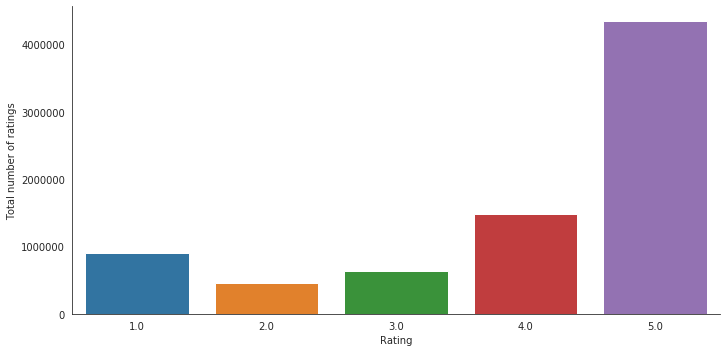

In [13]:
# Check the distribution of ratings 
with sns.axes_style('white'):
    g = sns.factorplot("Rating", data=df, aspect=2.0,kind='count')
    g.set_ylabels("Total number of ratings") 

In [14]:
# Number of unique user id and product id in the data
print('Number of unique USERS in Raw data = ', df['userId'].nunique())
print('Number of unique ITEMS in Raw data = ', df['productId'].nunique())

Number of unique USERS in Raw data =  4201696
Number of unique ITEMS in Raw data =  476002


### 2. Take a subset of the dataset to make it less sparse/ denser.( For example, keep the users only who has given 50 or more number of ratings ) - (2.5 Marks)

In [15]:
# Top 10 users based on rating
most_rated = df.groupby('userId').size().sort_values(ascending=False)[:10]
most_rated

userId
A5JLAU2ARJ0BO     520
ADLVFFE4VBT8      501
A3OXHLG6DIBRW8    498
A6FIAB28IS79      431
A680RUE1FDO8B     406
A1ODOGXEYECQQ8    380
A36K2N527TXXJN    314
A2AY4YUOX2N1BQ    311
AWPODHOB4GFWL     308
A25C2M3QF9G7OQ    296
dtype: int64

In [16]:
counts = df['userId'].value_counts()
counts

A5JLAU2ARJ0BO     520
ADLVFFE4VBT8      501
A3OXHLG6DIBRW8    498
A6FIAB28IS79      431
A680RUE1FDO8B     406
                 ... 
A2IEZLVV0FPLS7      1
A34YGH4M8CAVWE      1
A15PE20AT9UBVX      1
A1TDYIXMMLG6VA      1
A234RY1UU087WX      1
Name: userId, Length: 4201696, dtype: int64

Filtering the data with 50 or more rating

In [17]:
df_final = df[df['userId'].isin(counts[counts >= 50].index)]
df_final

,userId,productId,Rating,timestamp
94,A3BY5KCNQZXV5U,0594451647,5.0,1390176000
118,AT09WGFUM934H,0594481813,3.0,1377907200
177,A32HSNCNPRUMTR,0970407998,1.0,1319673600
178,A17HMM1M7T9PJ1,0970407998,4.0,1281744000
492,A3CLWR1UUZT6TG,0972683275,5.0,1373587200
...,...,...,...,...
7824426,A1E1LEVQ9VQNK,B00LGQ6HL8,5.0,1405641600
7824427,A2NYK9KWFMJV4Y,B00LGQ6HL8,5.0,1405209600
7824436,A3AYSYSLHU26U9,B00LI4ZZO8,4.0,1405296000
7824438,A2NYK9KWFMJV4Y,B00LI4ZZO8,5.0,1405209600


In [18]:
print('Number of users who have rated 50 or more items =', len(df_final))
print('Number of unique USERS in final data = ', df_final['userId'].nunique())
print('Number of unique ITEMS in final data = ', df_final['userId'].nunique())

Number of users who have rated 50 or more items = 125871
Number of unique USERS in final data =  1540
Number of unique ITEMS in final data =  1540


Calculate the density of the rating matrix

In [19]:
final_ratings_matrix = df_final.pivot(index = 'userId', columns ='productId', values = 'Rating').fillna(0)
print('Shape of final_ratings_matrix: ', final_ratings_matrix.shape)
given_num_of_ratings = np.count_nonzero(final_ratings_matrix)
print('given_num_of_ratings = ', given_num_of_ratings)
possible_num_of_ratings = final_ratings_matrix.shape[0] * final_ratings_matrix.shape[1]
print('possible_num_of_ratings = ', possible_num_of_ratings)
density = (given_num_of_ratings/possible_num_of_ratings)
density *= 100
print ('density: {:4.2f}%'.format(density))

Shape of final_ratings_matrix:  (1540, 48190)
given_num_of_ratings =  125871
possible_num_of_ratings =  74212600
density: 0.17%


In [20]:
final_ratings_matrix.head()

productId,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,1400599997,1400698987,1400699169,1685560148,3744295508,7562434166,787988002X,8862935307,8862936826,9043413585,9573212900,9573212919,9575871979,9800359788,9981719005,9981734241,9981739588,9983722615,998376234X,9983891212,9984922626,9984984362,9985511298,9985511476,9985525264,9985696999,9989360391,B000000O48,B000001OKH,B000001OL6,...,B00KSTODWY,B00KT17TZ4,B00KTIYN7O,B00KU4RD4M,B00KV6FFN0,B00KVLY8E2,B00KVNY2KA,B00KW2W6B2,B00KW3OFG0,B00KWHMR6G,B00KWL62QI,B00KWMNDDM,B00KWPRSJY,B00KWWY1PQ,B00KXAFYZS,B00KXMN08E,B00KXUHX9S,B00KYA7CT8,B00KYMCJF8,B00L0YFJHY,B00L1I727Y,B00L1I80K2,B00L1NZTSS,B00L21HC7A,B00L2442H0,B00L26YDA4,B00L2P3TRS,B00L3YHF6O,B00L403O94,B00L43HAY6,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
# Matrix with one row per 'Product' and one column per 'user' for Item-based CF
final_ratings_matrix_T = final_ratings_matrix.transpose()
final_ratings_matrix_T.head()

userId,A100UD67AHFODS,A100WO06OQR8BQ,A105S56ODHGJEK,A105TOJ6LTVMBG,A10AFVU66A79Y1,A10H24TDLK2VDP,A10NMELR4KX0J6,A10O7THJ2O20AG,A10PEXB6XAQ5XF,A10X9ME6R66JDX,A10Y058K7B96C6,A10ZBR6O8S8OCY,A10ZFE6YE0UHW8,A110PC8C5Y7MQD,A110VKXAVLAYKY,A111WCUF5KA2I6,A1143YEAZYMYHJ,A11D1KHM7DVOQK,A11ED8O95W2103,A11EXFO14WEJM1,A11EYMH9UV9XG7,A11FX8HL2ANK6T,A11I1I9QLMAM1A,A11IXJ8M1JO296,A11KQADBYE0UZL,A11KZ906QD08C5,A11LNPG39A2ZV4,A11OTLEDSW8ZXD,A11P105WVK5240,A11R5VW7IM6ISQ,A11T807LX2EF00,A11ULAZ4B5ZXC8,A11YIHB6IW352W,A11YOTONCPRQ9S,A124WZCUIH2T7W,A12ANFNOSMW5VD,A12DLJESJKM1OQ,A12DQZKRKTNF5E,A12EVK82QUTSA6,A12LH2100CKQO,...,AW6FQE5QRF2LM,AW6J9IILGOZY3,AWH2AY17ZU7W2,AWHL379EE14K7,AWJWCKB92RJX2,AWNBZSEZ9P8BE,AWNJAY0M5UI70,AWPN47SSWK1JV,AWPODHOB4GFWL,AWSK1ZAEU1KFL,AWZR0O65DL2Q,AX05DBU8IRUWY,AX7317G153T8W,AXP8GO5Q3AXSA,AXR3CV6A4FMBG,AXU3VKZE848IY,AXU8RH1DEV21H,AXYM52DNK6NDF,AY3D7DG5L5WCK,AY3XPKRAMKKY7,AY4EXFOO43C3S,AY6A8KPYCE6B0,AYB4ELCS5AM8P,AYCAIHABPYWVJ,AYGEKID3G7DPW,AYLLSFYS3UP1H,AYMD77ITD15PT,AYNAH993VDECT,AYO1146CBIV5C,AYOMAHLWRQHUG,AYOTEJ617O60K,AYP0YPLSP9ISM,AZ515FFZ7I2P7,AZ8XSDMIX04VJ,AZAC8O310IK4E,AZBXKUH4AIW3X,AZCE11PSTCH1L,AZMY6E8B52L2T,AZNUHQSHZHSUE,AZOK5STV85FBJ
productId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0594451647,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0594481813,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0970407998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0972683275,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1400501466,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 3. Split the data randomly into train and test dataset. ( For example, split it in 70/30 ratio) - (2.5 Marks)

In [22]:
#Split the data randomnly into test and train datasets
#Split the training and test data in the ratio 70:30
train_data, test_data = train_test_split(df_final, test_size = 0.3, random_state=0)
train_data.head()

,userId,productId,Rating,timestamp
6595853,A2BYV7S1QP2YIG,B009EAHVTA,5.0,1399161600
4738241,AB094YABX21WQ,B0056XCEAA,1.0,1315267200
4175596,A3D0UM4ZD2CMAW,B004I763AW,5.0,1355616000
3753016,AATWFX0ZZSE6C,B0040NPHMO,3.0,1293753600
1734767,A1NNMOD9H36Q8E,B0015VW3BM,4.0,1220313600


In [23]:
train_data.shape
test_data.shape

(88109, 4)

(37762, 4)

### 4. Build Popularity Recommender model. - (20 Marks)

In [24]:
#Count of user_id for each unique product as recommendation score 
train_data_grouped = train_data.groupby('productId').agg({'userId' : 'count'}).reset_index()
train_data_grouped.rename(columns = {'userId': 'score'},inplace=True)
train_data_grouped.head()

,productId,score
0,0594451647,1
1,0594481813,1
2,0970407998,1
3,0972683275,3
4,1400501466,4


In [25]:
#Sort the products on recommendation score 
train_data_sort = train_data_grouped.sort_values(['score', 'productId'], ascending = [0,1]) 
train_data_sort

,productId,score
30847,B0088CJT4U,133
30287,B007WTAJTO,124
19647,B003ES5ZUU,122
8752,B000N99BBC,114
30555,B00829THK0,97
...,...,...
38218,B00L403O94,1
38219,B00L5YZCCG,1
38222,B00LBZ1Z7K,1
38223,B00LED02VY,1


In [26]:
#Generate a recommendation rank based upon score 
train_data_sort['Rank'] = train_data_sort['score'].rank(ascending=0, method='first') 
train_data_sort['Rank'] 

30847        1.0
30287        2.0
19647        3.0
8752         4.0
30555        5.0
          ...   
38218    38222.0
38219    38223.0
38222    38224.0
38223    38225.0
38225    38226.0
Name: Rank, Length: 38226, dtype: float64

In [27]:
          #Get the top 5 recommendations 
popularity_recommendations = train_data_sort.head(5) 
popularity_recommendations 

,productId,score,Rank
30847,B0088CJT4U,133,1.0
30287,B007WTAJTO,124,2.0
19647,B003ES5ZUU,122,3.0
8752,B000N99BBC,114,4.0
30555,B00829THK0,97,5.0


In [0]:
# Use popularity based recommender model to make predictions
def recommend(user_id):     
    user_recommendations = popularity_recommendations 
          
    #Add user_id column for which the recommendations are being generated 
    user_recommendations['userID'] = user_id 
      
    #Bring user_id column to the front 
    cols = user_recommendations.columns.tolist() 
    cols = cols[-1:] + cols[:-1] 
    user_recommendations = user_recommendations[cols] 
          
    return user_recommendations 

In [29]:
find_recom = [6595853,4175596,1734767]   # This list is user choice.
for i in find_recom:
    print("Here is the recommendation for the userId: %d\n" %(i))
    print(recommend(i))    
    print("\n") 

Here is the recommendation for the userId: 6595853

        userID   productId  score  Rank
30847  6595853  B0088CJT4U    133   1.0
30287  6595853  B007WTAJTO    124   2.0
19647  6595853  B003ES5ZUU    122   3.0
8752   6595853  B000N99BBC    114   4.0
30555  6595853  B00829THK0     97   5.0


Here is the recommendation for the userId: 4175596

        userID   productId  score  Rank
30847  4175596  B0088CJT4U    133   1.0
30287  4175596  B007WTAJTO    124   2.0
19647  4175596  B003ES5ZUU    122   3.0
8752   4175596  B000N99BBC    114   4.0
30555  4175596  B00829THK0     97   5.0


Here is the recommendation for the userId: 1734767

        userID   productId  score  Rank
30847  1734767  B0088CJT4U    133   1.0
30287  1734767  B007WTAJTO    124   2.0
19647  1734767  B003ES5ZUU    122   3.0
8752   1734767  B000N99BBC    114   4.0
30555  1734767  B00829THK0     97   5.0




### Since this is a popularity-based recommender model, recommendations remain the same for all users

### We predict the products based on the popularity. It is not personalized to particular user

### 5. Build Collaborative Filtering model. - (20 Marks)

### Model-based Collaborative Filtering: Singular Value Decomposition

In [30]:
df_CF = pd.concat([train_data, test_data]).reset_index()
df_CF.head()

,index,userId,productId,Rating,timestamp
0,6595853,A2BYV7S1QP2YIG,B009EAHVTA,5.0,1399161600
1,4738241,AB094YABX21WQ,B0056XCEAA,1.0,1315267200
2,4175596,A3D0UM4ZD2CMAW,B004I763AW,5.0,1355616000
3,3753016,AATWFX0ZZSE6C,B0040NPHMO,3.0,1293753600
4,1734767,A1NNMOD9H36Q8E,B0015VW3BM,4.0,1220313600


In [31]:
#User-based Collaborative Filtering
# Matrix with row per 'user' and column per 'item' 
pivot_df = df_CF.pivot(index = 'userId', columns ='productId', values = 'Rating').fillna(0)
pivot_df.shape
pivot_df.head()

(1540, 48190)

productId,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,1400599997,1400698987,1400699169,1685560148,3744295508,7562434166,787988002X,8862935307,8862936826,9043413585,9573212900,9573212919,9575871979,9800359788,9981719005,9981734241,9981739588,9983722615,998376234X,9983891212,9984922626,9984984362,9985511298,9985511476,9985525264,9985696999,9989360391,B000000O48,B000001OKH,B000001OL6,...,B00KSTODWY,B00KT17TZ4,B00KTIYN7O,B00KU4RD4M,B00KV6FFN0,B00KVLY8E2,B00KVNY2KA,B00KW2W6B2,B00KW3OFG0,B00KWHMR6G,B00KWL62QI,B00KWMNDDM,B00KWPRSJY,B00KWWY1PQ,B00KXAFYZS,B00KXMN08E,B00KXUHX9S,B00KYA7CT8,B00KYMCJF8,B00L0YFJHY,B00L1I727Y,B00L1I80K2,B00L1NZTSS,B00L21HC7A,B00L2442H0,B00L26YDA4,B00L2P3TRS,B00L3YHF6O,B00L403O94,B00L43HAY6,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
pivot_df['user_index'] = np.arange(0, pivot_df.shape[0], 1)
pivot_df.head()

productId,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,1400599997,1400698987,1400699169,1685560148,3744295508,7562434166,787988002X,8862935307,8862936826,9043413585,9573212900,9573212919,9575871979,9800359788,9981719005,9981734241,9981739588,9983722615,998376234X,9983891212,9984922626,9984984362,9985511298,9985511476,9985525264,9985696999,9989360391,B000000O48,B000001OKH,B000001OL6,...,B00KT17TZ4,B00KTIYN7O,B00KU4RD4M,B00KV6FFN0,B00KVLY8E2,B00KVNY2KA,B00KW2W6B2,B00KW3OFG0,B00KWHMR6G,B00KWL62QI,B00KWMNDDM,B00KWPRSJY,B00KWWY1PQ,B00KXAFYZS,B00KXMN08E,B00KXUHX9S,B00KYA7CT8,B00KYMCJF8,B00L0YFJHY,B00L1I727Y,B00L1I80K2,B00L1NZTSS,B00L21HC7A,B00L2442H0,B00L26YDA4,B00L2P3TRS,B00L3YHF6O,B00L403O94,B00L43HAY6,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8,user_index
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


In [33]:
pivot_df.set_index(['user_index'], inplace=True)

# Actual ratings given by users
pivot_df.head()

productId,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,1400599997,1400698987,1400699169,1685560148,3744295508,7562434166,787988002X,8862935307,8862936826,9043413585,9573212900,9573212919,9575871979,9800359788,9981719005,9981734241,9981739588,9983722615,998376234X,9983891212,9984922626,9984984362,9985511298,9985511476,9985525264,9985696999,9989360391,B000000O48,B000001OKH,B000001OL6,...,B00KSTODWY,B00KT17TZ4,B00KTIYN7O,B00KU4RD4M,B00KV6FFN0,B00KVLY8E2,B00KVNY2KA,B00KW2W6B2,B00KW3OFG0,B00KWHMR6G,B00KWL62QI,B00KWMNDDM,B00KWPRSJY,B00KWWY1PQ,B00KXAFYZS,B00KXMN08E,B00KXUHX9S,B00KYA7CT8,B00KYMCJF8,B00L0YFJHY,B00L1I727Y,B00L1I80K2,B00L1NZTSS,B00L21HC7A,B00L2442H0,B00L26YDA4,B00L2P3TRS,B00L3YHF6O,B00L403O94,B00L43HAY6,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
user_index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## SVD method

In [0]:
from scipy.sparse.linalg import svds
# Singular Value Decomposition
U, sigma, Vt = svds(pivot_df, k = 10)
# Construct diagonal array in SVD
sigma = np.diag(sigma)

In [35]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 

# Predicted ratings
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = pivot_df.columns)
preds_df.head()

productId,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,1400599997,1400698987,1400699169,1685560148,3744295508,7562434166,787988002X,8862935307,8862936826,9043413585,9573212900,9573212919,9575871979,9800359788,9981719005,9981734241,9981739588,9983722615,998376234X,9983891212,9984922626,9984984362,9985511298,9985511476,9985525264,9985696999,9989360391,B000000O48,B000001OKH,B000001OL6,...,B00KSTODWY,B00KT17TZ4,B00KTIYN7O,B00KU4RD4M,B00KV6FFN0,B00KVLY8E2,B00KVNY2KA,B00KW2W6B2,B00KW3OFG0,B00KWHMR6G,B00KWL62QI,B00KWMNDDM,B00KWPRSJY,B00KWWY1PQ,B00KXAFYZS,B00KXMN08E,B00KXUHX9S,B00KYA7CT8,B00KYMCJF8,B00L0YFJHY,B00L1I727Y,B00L1I80K2,B00L1NZTSS,B00L21HC7A,B00L2442H0,B00L26YDA4,B00L2P3TRS,B00L3YHF6O,B00L403O94,B00L43HAY6,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
0,0.002661,0.003576,0.004050,0.006906,0.003967,0.003073,0.005782,0.000568,0.014386,0.002708,0.002740,0.005144,0.007609,0.006248,0.002238,0.001380,0.007490,0.006603,-0.002774,-0.000611,0.005742,0.003352,0.006948,0.033771,0.050016,0.000428,0.007371,0.003793,0.002188,0.029240,0.001328,0.002442,0.000597,0.001121,0.000998,0.000971,0.002601,0.000362,0.003866,0.002477,...,0.004195,0.013884,0.029770,0.009769,0.000328,1.786030e-02,0.214161,0.012370,-0.007345,0.001119,0.097072,0.059136,0.007721,0.053163,0.070980,-0.002634,0.001039,0.015014,0.160980,1.786030e-02,0.038927,0.111473,-0.001243,0.280426,0.233076,0.228136,0.031142,0.301215,-0.001294,-0.001795,6.108890e-04,0.044224,0.002919,0.060347,-0.002137,0.006751,0.001525,0.130951,0.059243,0.015014
1,0.002262,0.002505,0.005136,0.016517,0.007120,0.001438,0.013258,0.000335,-0.003781,0.001190,0.011586,0.005878,0.013008,0.004533,0.000138,0.000710,0.012295,0.002374,0.003437,0.004322,0.003412,0.001510,0.003783,0.005507,0.016031,0.000684,0.004313,0.002023,0.004701,0.027990,-0.000307,0.000941,0.000192,0.000031,0.000703,0.000968,0.004060,-0.000222,0.002816,0.000823,...,0.016443,0.001595,0.019103,0.003627,-0.000063,9.059451e-03,0.001982,-0.002046,0.014991,0.008442,-0.015009,-0.023460,0.006261,-0.003664,0.023399,0.005163,0.000143,0.003696,-0.000358,9.059451e-03,-0.013860,0.024497,0.010264,0.018962,0.010708,0.012312,-0.011088,0.138789,0.005661,0.028307,2.024793e-04,0.029213,0.000010,0.000244,-0.003111,-0.000621,0.004409,-0.039241,-0.006889,0.003696
2,-0.001600,-0.002502,0.002186,0.016742,0.006716,-0.002113,0.005805,0.003497,-0.005009,-0.001588,0.010652,-0.001785,0.003712,-0.003400,-0.001470,-0.000858,0.003583,-0.006089,0.011940,0.012993,-0.003396,-0.001812,-0.004454,0.014428,-0.009288,-0.000064,-0.004780,-0.002592,-0.000178,-0.004091,-0.001010,-0.002195,-0.000425,-0.000617,-0.000531,-0.000415,0.001746,0.000361,-0.002415,-0.001121,...,0.002614,0.020184,0.006436,-0.006516,-0.000314,-4.245947e-03,-0.014910,0.004824,0.054930,0.004780,-0.014461,0.005226,0.008377,0.030376,0.022412,0.027762,-0.000435,-0.004525,0.001284,-4.245947e-03,-0.016335,-0.021634,0.009076,0.006990,-0.025551,-0.006922,-0.013068,0.050088,0.016156,0.026709,-3.240446e-04,0.009180,-0.002459,-0.016922,0.019936,-0.002483,-0.000155,-0.002889,-0.011522,-0.004525
3,0.002732,0.003867,0.001799,0.009395,0.004075,0.002778,0.003507,0.000095,0.007983,0.002381,0.001405,0.006250,0.006382,0.007611,0.001493,0.001514,0.005035,0.007532,-0.001492,0.003372,0.004802,0.002732,0.005770,-0.004952,0.009293,0.000490,0.006350,0.003464,0.002064,0.024304,0.001529,0.002537,0.000518,0.000760,0.000549,0.000974,0.001333,-0.000058,0.002827,0.001547,...,0.009978,-0.004203,0.001358,0.011285,0.000290,1.072706e-03,-0.006264,-0.004407,-0.005160,0.000752,0.004034,0.009716,-0.003497,-0.018021,-0.008387,-0.002492,0.000454,0.003276,0.009347,1.072706e-03,-0.003291,0.018267,-0.001003,-0.008367,-0.000026,-0.007925,-0.002632,0.022344,-0.001748,-0.005637,6.031462e-04,-0.003369,0.003433,-0.003428,-0.000750,0.000119,0.002612,-0.015107,-0.006740,0.003276
4,0.000704,0.000085,0.002051,0.009664,0.004438,0.000335,0.0

In [0]:
# Recommend the items with the highest predicted ratings

def recommend_items(userID, pivot_df, preds_df, num_recommendations):
      
    user_idx = userID-1 # index starts at 0
    
    # Get and sort the user's ratings
    sorted_user_ratings = pivot_df.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_ratings
    sorted_user_predictions = preds_df.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_predictions

    temp = pd.concat([sorted_user_ratings, sorted_user_predictions], axis=1)
    temp.index.name = 'Recommended Items'
    temp.columns = ['user_ratings', 'user_predictions']
    
    temp = temp.loc[temp.user_ratings == 0]   
    temp = temp.sort_values('user_predictions', ascending=False)
    print('\nBelow are the recommended items for user(user_id = {}):\n'.format(userID))
    print(temp.head(num_recommendations))

In [37]:
#Enter 'userID' and 'num_recommendations' for the user #
userID = 12
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 12):

                   user_ratings  user_predictions
Recommended Items                                
B0088CJT4U                  0.0          1.639356
B000N99BBC                  0.0          1.328095
B00829TIEK                  0.0          1.269074
B008DWCRQW                  0.0          1.145459
B004CLYEDC                  0.0          1.125218


### 6. Evaluate both the models. ( Once the model is trained on the training data, it can be used to compute the error(RMSE) on predictions made on the test data.) - (7.5 Marks)

### Evaluation of Model-based Collaborative Filtering (SVD)

In [38]:
# Actual ratings given by the users
final_ratings_matrix.head()

productId,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,1400599997,1400698987,1400699169,1685560148,3744295508,7562434166,787988002X,8862935307,8862936826,9043413585,9573212900,9573212919,9575871979,9800359788,9981719005,9981734241,9981739588,9983722615,998376234X,9983891212,9984922626,9984984362,9985511298,9985511476,9985525264,9985696999,9989360391,B000000O48,B000001OKH,B000001OL6,...,B00KSTODWY,B00KT17TZ4,B00KTIYN7O,B00KU4RD4M,B00KV6FFN0,B00KVLY8E2,B00KVNY2KA,B00KW2W6B2,B00KW3OFG0,B00KWHMR6G,B00KWL62QI,B00KWMNDDM,B00KWPRSJY,B00KWWY1PQ,B00KXAFYZS,B00KXMN08E,B00KXUHX9S,B00KYA7CT8,B00KYMCJF8,B00L0YFJHY,B00L1I727Y,B00L1I80K2,B00L1NZTSS,B00L21HC7A,B00L2442H0,B00L26YDA4,B00L2P3TRS,B00L3YHF6O,B00L403O94,B00L43HAY6,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [39]:
# Average ACTUAL rating for each item
final_ratings_matrix.mean().head()

productId
0594451647    0.003247
0594481813    0.001948
0970407998    0.003247
0972683275    0.012338
1400501466    0.012987
dtype: float64

In [40]:
# Predicted ratings 
preds_df.head()

productId,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,1400599997,1400698987,1400699169,1685560148,3744295508,7562434166,787988002X,8862935307,8862936826,9043413585,9573212900,9573212919,9575871979,9800359788,9981719005,9981734241,9981739588,9983722615,998376234X,9983891212,9984922626,9984984362,9985511298,9985511476,9985525264,9985696999,9989360391,B000000O48,B000001OKH,B000001OL6,...,B00KSTODWY,B00KT17TZ4,B00KTIYN7O,B00KU4RD4M,B00KV6FFN0,B00KVLY8E2,B00KVNY2KA,B00KW2W6B2,B00KW3OFG0,B00KWHMR6G,B00KWL62QI,B00KWMNDDM,B00KWPRSJY,B00KWWY1PQ,B00KXAFYZS,B00KXMN08E,B00KXUHX9S,B00KYA7CT8,B00KYMCJF8,B00L0YFJHY,B00L1I727Y,B00L1I80K2,B00L1NZTSS,B00L21HC7A,B00L2442H0,B00L26YDA4,B00L2P3TRS,B00L3YHF6O,B00L403O94,B00L43HAY6,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
0,0.002661,0.003576,0.004050,0.006906,0.003967,0.003073,0.005782,0.000568,0.014386,0.002708,0.002740,0.005144,0.007609,0.006248,0.002238,0.001380,0.007490,0.006603,-0.002774,-0.000611,0.005742,0.003352,0.006948,0.033771,0.050016,0.000428,0.007371,0.003793,0.002188,0.029240,0.001328,0.002442,0.000597,0.001121,0.000998,0.000971,0.002601,0.000362,0.003866,0.002477,...,0.004195,0.013884,0.029770,0.009769,0.000328,1.786030e-02,0.214161,0.012370,-0.007345,0.001119,0.097072,0.059136,0.007721,0.053163,0.070980,-0.002634,0.001039,0.015014,0.160980,1.786030e-02,0.038927,0.111473,-0.001243,0.280426,0.233076,0.228136,0.031142,0.301215,-0.001294,-0.001795,6.108890e-04,0.044224,0.002919,0.060347,-0.002137,0.006751,0.001525,0.130951,0.059243,0.015014
1,0.002262,0.002505,0.005136,0.016517,0.007120,0.001438,0.013258,0.000335,-0.003781,0.001190,0.011586,0.005878,0.013008,0.004533,0.000138,0.000710,0.012295,0.002374,0.003437,0.004322,0.003412,0.001510,0.003783,0.005507,0.016031,0.000684,0.004313,0.002023,0.004701,0.027990,-0.000307,0.000941,0.000192,0.000031,0.000703,0.000968,0.004060,-0.000222,0.002816,0.000823,...,0.016443,0.001595,0.019103,0.003627,-0.000063,9.059451e-03,0.001982,-0.002046,0.014991,0.008442,-0.015009,-0.023460,0.006261,-0.003664,0.023399,0.005163,0.000143,0.003696,-0.000358,9.059451e-03,-0.013860,0.024497,0.010264,0.018962,0.010708,0.012312,-0.011088,0.138789,0.005661,0.028307,2.024793e-04,0.029213,0.000010,0.000244,-0.003111,-0.000621,0.004409,-0.039241,-0.006889,0.003696
2,-0.001600,-0.002502,0.002186,0.016742,0.006716,-0.002113,0.005805,0.003497,-0.005009,-0.001588,0.010652,-0.001785,0.003712,-0.003400,-0.001470,-0.000858,0.003583,-0.006089,0.011940,0.012993,-0.003396,-0.001812,-0.004454,0.014428,-0.009288,-0.000064,-0.004780,-0.002592,-0.000178,-0.004091,-0.001010,-0.002195,-0.000425,-0.000617,-0.000531,-0.000415,0.001746,0.000361,-0.002415,-0.001121,...,0.002614,0.020184,0.006436,-0.006516,-0.000314,-4.245947e-03,-0.014910,0.004824,0.054930,0.004780,-0.014461,0.005226,0.008377,0.030376,0.022412,0.027762,-0.000435,-0.004525,0.001284,-4.245947e-03,-0.016335,-0.021634,0.009076,0.006990,-0.025551,-0.006922,-0.013068,0.050088,0.016156,0.026709,-3.240446e-04,0.009180,-0.002459,-0.016922,0.019936,-0.002483,-0.000155,-0.002889,-0.011522,-0.004525
3,0.002732,0.003867,0.001799,0.009395,0.004075,0.002778,0.003507,0.000095,0.007983,0.002381,0.001405,0.006250,0.006382,0.007611,0.001493,0.001514,0.005035,0.007532,-0.001492,0.003372,0.004802,0.002732,0.005770,-0.004952,0.009293,0.000490,0.006350,0.003464,0.002064,0.024304,0.001529,0.002537,0.000518,0.000760,0.000549,0.000974,0.001333,-0.000058,0.002827,0.001547,...,0.009978,-0.004203,0.001358,0.011285,0.000290,1.072706e-03,-0.006264,-0.004407,-0.005160,0.000752,0.004034,0.009716,-0.003497,-0.018021,-0.008387,-0.002492,0.000454,0.003276,0.009347,1.072706e-03,-0.003291,0.018267,-0.001003,-0.008367,-0.000026,-0.007925,-0.002632,0.022344,-0.001748,-0.005637,6.031462e-04,-0.003369,0.003433,-0.003428,-0.000750,0.000119,0.002612,-0.015107,-0.006740,0.003276
4,0.000704,0.000085,0.002051,0.009664,0.004438,0.000335,0.0

In [41]:
# Average PREDICTED rating for each item
preds_df.mean().head()

productId
0594451647    0.001542
0594481813    0.002341
0970407998    0.002597
0972683275    0.011807
1400501466    0.004848
dtype: float64

In [42]:
rmse_df = pd.concat([final_ratings_matrix.mean(), preds_df.mean()], axis=1)
rmse_df.columns = ['Avg_actual_ratings', 'Avg_predicted_ratings']
print(rmse_df.shape)

(48190, 2)


In [43]:
rmse_df['item_index'] = np.arange(0, rmse_df.shape[0], 1)
rmse_df.head()

,Avg_actual_ratings,Avg_predicted_ratings,item_index
productId,,,
0594451647,0.003247,0.001542,0
0594481813,0.001948,0.002341,1
0970407998,0.003247,0.002597,2
0972683275,0.012338,0.011807,3
1400501466,0.012987,0.004848,4


In [44]:
RMSE = round((((rmse_df.Avg_actual_ratings - rmse_df.Avg_predicted_ratings) ** 2).mean() ** 0.5), 5)
print('\nRMSE SVD Model = {} \n'.format(RMSE))


RMSE SVD Model = 0.0033 



Best RMSE obtained.

### 7. Get top - K ( K = 5) recommendations. Since our goal is to recommend new products for each user based on his/her habits, we will recommend 5 new products. - (7.5 Marks)


In [45]:
# Enter 'userID' and 'num_recommendations' for the user #
userID = 20
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 20):

                   user_ratings  user_predictions
Recommended Items                                
B0088CJT4U                  0.0          1.524522
B00829TIEK                  0.0          1.335672
B000N99BBC                  0.0          1.262374
B008DWCRQW                  0.0          1.062069
B004CLYEDC                  0.0          1.014894


### 8. Summarise your insights. - (7.5 marks)

Model-based Collaborative Filtering is a personalised recommender system, the recommendations are based on the past behavior of the user and it is not dependent on any additional information.

The Popularity-based recommender system is non-personalised and the recommendations are based on frequecy counts, which may be not suitable to the user.The Popularity based model has recommended the same set of 5 products to both but Collaborative Filtering based model has recommended entire different list based on the user past purchase history.